In [1]:
# # For Sentinel-2
# # !pip install sentinelsat
# import sys
# !{sys.executable} -m pip install sentinelsat

In [2]:
import ee
import geemap
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Function to compute NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8','B4']).rename('NDVI')
    return image.addBands(ndvi)


# Reduce over vineyard
def reduce_region(image, geom, plot_id):
    mean_ndvi = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=10
    )
    return ee.Feature(None, {
        'date': image.date().format(),
        'plot_id': plot_id,
        'mean_ndvi': mean_ndvi.get('NDVI')
    })


In [4]:
ee.Initialize()

# Load your vineyard polygon (GeoJSON)
vineyard = gpd.read_file("data/polygons/RegressionRidge.geojson")
# geom = ee.Geometry.Polygon(list(vineyard.geometry[0].exterior.coords))
# Assuming vineyard has 65 polygons
geoms = [ee.Geometry.Polygon(list(p.exterior.coords)) for p in vineyard.geometry]


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [5]:
years = [str(year) for year in range(2016, 2025, 1)]
months = ['01', '12']
days = ['01', '31']
start_dates = [year + '-' + months[0] + '-' + days[0] for year in years]
end_dates = [year + '-' + months[1] + '-' + days[1] for year in years]

In [6]:
for start_date, end_date in tqdm(zip(start_dates, end_dates), total=len(start_dates)):
    fname = f"data/ndvi/ndvi_{start_date}_to_{end_date}.pkl"
    if os.path.isfile(fname):
        continue

    collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                  .filterBounds(geoms[0])  # bounds of all plots could be unioned
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40))
                  .select(['B4','B8']))
    
    collection = collection.map(add_ndvi)
    
    features = []
    for i, geom in enumerate(geoms):
        ndvi_ts = collection.map(lambda img: reduce_region(img, geom, i))
        features.extend(ndvi_ts.getInfo()['features'])

    # Convert to DataFrame
    df = pd.DataFrame({
        'date': [f['properties']['date'] for f in features],
        'plot_id': [f['properties']['plot_id'] for f in features],
        'ndvi': [f['properties']['mean_ndvi'] for f in features]
    })
    
    os.makedirs("data/ndvi", exist_ok=True)
    df.to_pickle(fname)


100%|██████████| 9/9 [00:00<00:00, 14850.01it/s]


In [7]:
df_list = []
empties = []
for file in tqdm(os.listdir('data/ndvi')):
    if file == '.ipynb_checkpoints':
        continue
    if file == 'plots':
        continue
    if file == 'ndvi_df.pkl':
        continue
    df = pd.read_pickle(os.path.join('data/ndvi', file))
    if df.empty:
        # print('empty')
        empties.append(file)
        
        continue
        
    # df = df[(df['date'].dt.dayofyear >= 90) & (df['date'].dt.dayofyear <= 300)]
    df['ndvi_smooth'] = df['ndvi'].rolling(window=14, center=True, min_periods=1).mean()

    df_list.append(df)

100%|██████████| 14/14 [00:00<00:00, 558.95it/s]


In [8]:
# df['year'] = pd.to_datetime(df['date']).dt.year

# stats = []
# for key, group in df.groupby('plot_id'):
#     # print(key, group)
#     for yr, data in group.groupby('year'):
#         # print(data)
#         variance = np.var(data['ndvi'])
#         mean = np.mean(data['ndvi'])
#         n = len(data['ndvi'])
#         stats.append({
#             'year':yr,
#             'plot':key,
#             'mean':mean,
#             'variance':variance,
#             'n':n
#         })
# ndvi_stats = pd.DataFrame(stats)

In [9]:

# Keep only growing season (optional)
start_doy, end_doy = 90, 300  # e.g., DOY 90-300

aligned_dfs = []
for df in df_list:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    df = df[(df['doy'] >= start_doy) & (df['doy'] <= end_doy)]
    # print(df)
    aligned_dfs.append(df[['doy','ndvi_smooth']])


In [10]:
aligned_dfs = []
for df in df_list:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    # optional: keep only growing season
    df = df[(df['doy'] >= 90) & (df['doy'] <= 300)]
    
    # Aggregate multiple observations per day
    df_daily = df.groupby('doy')['ndvi_smooth'].mean().reset_index()
    
    year = df['date'].dt.year.iloc[0]
    df_daily.rename(columns={'ndvi_smooth': year}, inplace=True)
    aligned_dfs.append(df_daily)


In [11]:
from functools import reduce

df_all = reduce(lambda left, right: pd.merge(left, right, on='doy', how='outer'), aligned_dfs)
df_all.set_index('doy', inplace=True)

# Sort by DOY to get a proper seasonal curve
df_all.sort_index(inplace=True)


In [12]:
df_all

,2016,2023,2020,2017,2022,2018,2019,2021,2024,2015
doy,,,,,,,,,,
90,NaN,NaN,NaN,NaN,NaN,NaN,0.219055,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,0.209308,NaN,NaN,NaN,0.188909,NaN
97,NaN,NaN,NaN,NaN,0.211306,NaN,NaN,NaN,NaN,NaN
98,NaN,NaN,0.271966,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,0.208989,NaN,NaN,NaN,0.210534,NaN,NaN,0.280457,0.191285,NaN
...,...,...,...,...,...,...,...,...,...,...
292,NaN,0.197228,NaN,NaN,0.235172,NaN,NaN,0.340205,NaN,NaN
294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.161677,0.183923
295,NaN,NaN,0.223493,NaN,NaN,0.206664,0.259539,NaN,NaN,NaN


In [13]:
mean_ndvi = df_all.mean(axis=1)
std_ndvi = df_all.std(axis=1)
n_years = df_all.shape[1]

ci_upper = mean_ndvi + 1.96 * std_ndvi / np.sqrt(n_years)
ci_lower = mean_ndvi - 1.96 * std_ndvi / np.sqrt(n_years)


In [14]:
window = 7  # days
mean_smooth = mean_ndvi.rolling(window, center=True, min_periods=1).mean()
ci_upper_smooth = ci_upper.rolling(window, center=True, min_periods=1).mean()
ci_lower_smooth = ci_lower.rolling(window, center=True, min_periods=1).mean()


In [15]:
doy_grid = np.arange(1, 366)  # 1 to 365


year_arrays = []

for df in df_list:
    df = df.copy()
    df['doy'] = df['date'].dt.dayofyear
    # Drop duplicate DOYs to avoid reindexing errors
    df = df.drop_duplicates(subset='doy')
    
    # Interpolate onto full grid
    s = pd.Series(df['ndvi_smooth'].values, index=df['doy'])
    s_interp = s.reindex(doy_grid).interpolate(method='linear', limit_direction='both')
    year_arrays.append(s_interp.values)

In [16]:
year_matrix = np.vstack(year_arrays)  # shape: (n_years, 365)

# Compute mean and standard deviation across years
mean_ndvi = np.nanmean(year_matrix, axis=0)
std_ndvi = np.nanstd(year_matrix, axis=0)

# Smooth with rolling window
window = 15  # roughly 2 weeks
mean_smooth = pd.Series(mean_ndvi).rolling(window, center=True, min_periods=1).mean().values
std_smooth = pd.Series(std_ndvi).rolling(window, center=True, min_periods=1).mean().values

# 95% confidence interval
ci_upper = mean_smooth + 1.96 * std_smooth
ci_lower = mean_smooth - 1.96 * std_smooth

Text(0.5, 1.0, 'Bayes Fields NDVI Seasonal Cycle (2016–2024)')

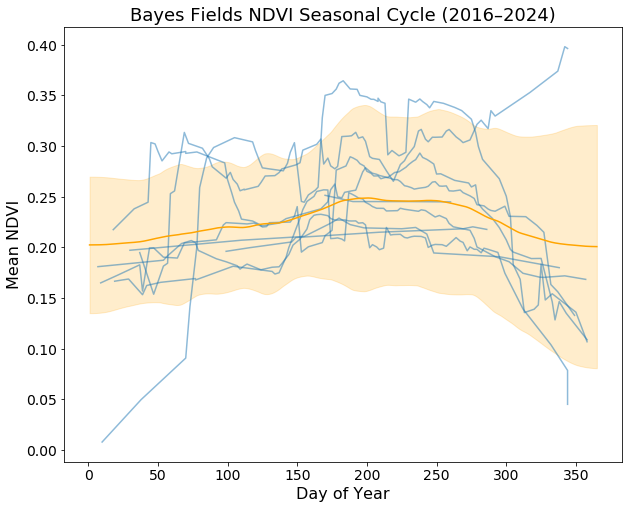

In [17]:
plt.figure(figsize = (10,8))

for df in df_list:
    # convert to datetime if not already
    df["date"] = pd.to_datetime(df["date"])
    # Assuming df['ndvi'] is sorted by date
    df['ndvi_smooth'] = df['ndvi'].rolling(window=5, center=True, min_periods=1).mean()

#     plt.plot(df['date'], df['ndvi'], alpha=0.2)
#     plt.plot(df['date'], df['ndvi_smooth'], color='green')

    # use day of year
    x = df["date"].dt.dayofyear
    # year = str(df['date'][-1].year)
    year = '2024'

    plt.plot(x, df["ndvi_smooth"], 
             label = year,
             color='#1f77b4',
             alpha=0.5
            )

plt.fill_between(doy_grid, ci_lower, ci_upper, color='orange', alpha=0.2, label='95% CI')
plt.plot(doy_grid, mean_smooth, color='orange', label='Mean NDVI (smoothed)')
plt.xlabel('Day of Year')
plt.ylabel('NDVI')
plt.title('Vineyard NDVI (Growing Season)')

plt.xlabel("Day of Year", fontsize = 16)
plt.ylabel("Mean NDVI", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Bayes Fields NDVI Seasonal Cycle (2016–2024)", fontsize = 18)

In [18]:
df_ndvi = pd.DataFrame({
    'doy': doy_grid,
    'mean_ndvi': mean_smooth,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

In [19]:
df_ndvi.to_pickle('data/ndvi/plots/ndvi_df.pkl')

In [20]:
df_ndvi

,doy,mean_ndvi,ci_lower,ci_upper
0,1,0.202510,0.135157,0.269863
1,2,0.202510,0.135157,0.269863
2,3,0.202513,0.135162,0.269863
3,4,0.202523,0.135199,0.269848
4,5,0.202540,0.135258,0.269823
...,...,...,...,...
360,361,0.200963,0.081179,0.320746
361,362,0.200917,0.081050,0.320785
362,363,0.200879,0.080940,0.320818
363,364,0.200850,0.080857,0.320844
